# Problem Statement

Veterinary invoices submitted to Trupanion often contain charges for more than one pet, as many owners have multiple pets. Therefore, when adjudicating an invoice we must determine which charges on an invoice relate to the pet named on the policy the owner is making a claim under. Use the data in the files Short_Assignment_LineitemData.csv and Short_Assignment_PolicyData.csv to construct a classifier to predict whether a lineitem (charge) is for the pet named on the policy or for another pet.

Note: ID numbers in Short_Assignment_LineitemData.csv correspond to those in Short_Assignment_PolicyData.csv, i.e. the owner with OwnerId = 1 in the LineItemData file is the same owner as that with OwnerId = 1 in the PolicyData file, and so on.

The expected outputs are predictions for the last 2000 rows of the Short_Assignment_LineitemData.csv, where the WrongPetFlag labels are currently ‘NA’. Please include both your predictions for these lineitems and the code used in this task in your submission.

# Eowyn Baughman: Solution

Note bene: boxplot_numerics() started crashing my jupyter notebook near the deadline so I have commented it out, but they are meant to be run.

# Import packages and data

In [1]:
import pandas as pd
import numpy as np
from nltk import edit_distance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from pprint import pprint
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

# Offline mode
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
lineitem = pd.read_csv('Short_Assignment_LineitemData.csv',parse_dates=['ClaimDate'])
lineitem.head()

,PolicyId,OwnerId,ClaimId,LineItemId,ClaimDate,PolicyPetName,ItemDescription,WrongPetFlag
0,0,0,0,0,2018-05-03,Justice,Justice: Cytopoint Vaccine 60.1-70 lbs,0.0
1,1,1,1,1,2018-05-01,Honey,Pepper: WHPlan CIV Vaccine & Booster -15% disc,1.0
2,2,2,2,2,2018-12-11,Bodhi,RILEY: Fluid Therapy Subcutaneous - LRS 300ml,1.0
3,3,3,3,3,2018-11-14,Gaston,Gaston: PCV/TP ADD IHLAB,0.0
4,4,4,4,4,2017-04-27,Dublin,Nellie: Fluorescein Stain.,1.0


In [3]:
policy = pd.read_csv('Short_Assignment_PolicyData.csv', parse_dates=['EnrollDate','CancelDate'])
policy.head()

,PolicyPetName,EnrollDate,CancelDate,PolicyId,OwnerId
0,Venom,2007-06-30,2013-04-04,17408,11376
1,Einstein cancelled policy,2007-08-13,2009-03-31,17470,3729
2,Roxy,2007-04-27,2014-10-09,16892,15963
3,Ruff,2007-12-18,2014-05-04,17648,14703
4,Simba,2007-06-14,2010-10-27,17729,7266


# Examine Data
For each file individually, look for missing values, outliers, unexpected data types, summary statistics, especially are the values reasonable for these fields. This data was quite clean, only one missing value to handle and no apparent outliers. I clean the line item data first, and 

In [4]:
# Review data integrity
def check_data(df):
    print('Nulls:\n',df.isna().sum())
    print(df.info())
    print(df.describe())
    print('NullRows:\n',df[df.isna().any(axis=1)])

In [5]:
check_data(lineitem)

Nulls:
 PolicyId              0
OwnerId               0
ClaimId               0
LineItemId            0
ClaimDate             0
PolicyPetName         0
ItemDescription       0
WrongPetFlag       2000
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PolicyId         20000 non-null  int64         
 1   OwnerId          20000 non-null  int64         
 2   ClaimId          20000 non-null  int64         
 3   LineItemId       20000 non-null  int64         
 4   ClaimDate        20000 non-null  datetime64[ns]
 5   PolicyPetName    20000 non-null  object        
 6   ItemDescription  20000 non-null  object        
 7   WrongPetFlag     18000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 1.2+ MB
None
           PolicyId       OwnerId       ClaimId    LineItemId  

In [6]:
check_data(policy)

Nulls:
 PolicyPetName        1
EnrollDate           0
CancelDate       19667
PolicyId             0
OwnerId              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32891 entries, 0 to 32890
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PolicyPetName  32890 non-null  object        
 1   EnrollDate     32891 non-null  datetime64[ns]
 2   CancelDate     13224 non-null  datetime64[ns]
 3   PolicyId       32891 non-null  int64         
 4   OwnerId        32891 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 1.3+ MB
None
           PolicyId       OwnerId
count  3.289100e+04  32891.000000
mean   5.840923e+05   7870.313034
std    7.396070e+05   4702.896269
min    0.000000e+00      0.000000
25%    8.222500e+03   3789.000000
50%    1.644500e+04   7737.000000
75%    1.126672e+06  11948.000000
max    2.328774e+06  16230.000000
NullRows:
       Po

In [7]:
# The missing PolicyPetName at row 679 (policy id 188089) must be handled
print(policy[policy.OwnerId==4452])
# This owner has two named pets, Tilly and Penelope. Both had polices active during
# the time period with policy 188089 that covered the NaN-named pet
print('Line Item:\n',lineitem[lineitem.OwnerId==4452])
# There is a claim flagged wrongly as Penelope with Penelope's PolicyId (wrong)
# with the name Chantilly attached to the ItemDescription. 

# The NaN PolicyPetName can be reasonably guessed as Chantilly
# And we see that PolicyId can be wrong in the lineitem data
policy.loc[policy.PolicyId==188089,'PolicyPetName'] = 'Chantilly'

      PolicyPetName EnrollDate CancelDate  PolicyId  OwnerId
668           Tilly 2015-08-14 2015-09-13    185600     4452
679             NaN 2015-08-31 2015-09-30    188089     4452
5347          Tilly 2016-06-05        NaT    629276     4452
12539      Penelope 2013-03-26 2016-04-18      4561     4452
30797         Tilly 2015-10-08 2016-04-18   2181406     4452
Line Item:
       PolicyId  OwnerId  ClaimId  LineItemId  ClaimDate PolicyPetName  \
4757      4561     4452     4731        4757 2015-11-23      Penelope   

                                       ItemDescription  WrongPetFlag  
4757  Chantilly:  Trifexis Blue 40.1 - 60# Single Dose           1.0  


# Feature Engineering
These data are rather limited -- we only have information about dates, IDs, names, and the vet's office description of the service, which thankfully also has a name attached. The useful features we can extract are:
* related to the names, and the degree to which they match one another
* related to seasonality (month, year)
* related to the policy, such as duration and whether it is still active

Once we have these features created, we will select the best ones to use in our classifier.

## Add features to Policy data

In [8]:
# We are told that missing CancelDates represent active policies
# Create a binary Active to indicate whether policy is active or not
policy[['Active']] = policy[['CancelDate']].isnull().astype(int)
# Also create duration of policy column, using today as end date on active policies
policy['CancelDate'].fillna(pd.Timestamp("20220328"), inplace=True)
policy['DurationDays'] = (policy['CancelDate']-policy['EnrollDate']).dt.days
# Extract month and year from enrollment date (available for all rows)
policy['EnrollMonth'] = policy.EnrollDate.dt.month
policy['EnrollYear'] = policy.EnrollDate.dt.year
# Check out one entry as sanity check
policy.iloc[4947]

PolicyPetName                   Gigi
EnrollDate       2019-06-28 00:00:00
CancelDate       2022-03-28 00:00:00
PolicyId                      615711
OwnerId                        10249
Active                             1
DurationDays                    1004
EnrollMonth                        6
EnrollYear                      2019
Name: 4947, dtype: object

In [9]:
# Check the data again. There are policies where DurationDays < 0 which appears to be
# because the EnrollDate and CancelDate are swapped. No active policies here.
# Unswap then recompute DurationDays,Enroll Yr/Month
#check_data(policy)
policy[policy['DurationDays']<0] # eg row 1642
m = policy['DurationDays']<0
mp = {'EnrollDate': 'CancelDate', 'CancelDate': 'EnrollDate'}
policy.update(policy.loc[m].rename(mp, axis=1))

policy.iloc[1642]

PolicyPetName                   Tina
EnrollDate       2018-10-15 00:00:00
CancelDate       2018-11-01 00:00:00
PolicyId                      318688
OwnerId                         9734
Active                             0
DurationDays                     -17
EnrollMonth                       11
EnrollYear                      2018
Name: 1642, dtype: object

In [10]:
# Recompute DurationDays, Enroll month and year
policy['DurationDays'] = (policy['CancelDate']-policy['EnrollDate']).dt.days
policy['EnrollMonth'] = policy.EnrollDate.dt.month
policy['EnrollYear'] = policy.EnrollDate.dt.year
policy.iloc[1642]

PolicyPetName                   Tina
EnrollDate       2018-10-15 00:00:00
CancelDate       2018-11-01 00:00:00
PolicyId                      318688
OwnerId                         9734
Active                             0
DurationDays                      17
EnrollMonth                       10
EnrollYear                      2018
Name: 1642, dtype: object

In [11]:
check_data(policy) # No more nulls or invalid values

Nulls:
 PolicyPetName    0
EnrollDate       0
CancelDate       0
PolicyId         0
OwnerId          0
Active           0
DurationDays     0
EnrollMonth      0
EnrollYear       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32891 entries, 0 to 32890
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PolicyPetName  32891 non-null  object        
 1   EnrollDate     32891 non-null  datetime64[ns]
 2   CancelDate     32891 non-null  datetime64[ns]
 3   PolicyId       32891 non-null  float64       
 4   OwnerId        32891 non-null  float64       
 5   Active         32891 non-null  float64       
 6   DurationDays   32891 non-null  int64         
 7   EnrollMonth    32891 non-null  int64         
 8   EnrollYear     32891 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(3), object(1)
memory usage: 2.3+ MB
None
           PolicyId       OwnerId        Active  Dura

Check out the distributions, as a fast way to confirm that we don't need to handle outliers. Plotly lets you zoom in so one plot is sufficient for all the variables regardless of scale. Note that we need to check for outliers before scaling the dataset or else the outliers will skew the scaling. 

In [12]:
def boxplot_numerics(df):
    # Horizontal box plots to show outliers, quartiles of distribution of numeric variables
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numdf = df.select_dtypes(include=numerics)

    fig = go.Figure()
    for col in numdf.columns:
        for col in numdf.columns:
            if col in (['PolicyId','OwnerId','LineItemId','ClaimId']):
                continue
            fig.add_trace(go.Box(x=numdf[col], name=col))
            fig.add_trace(go.Box(x=numdf[col], name=col))

    fig.update_layout(
        title="Box Plots, non-ID numeric columns",
        xaxis_title="Value",
        yaxis_title="Variable",
        showlegend=False)   
    fig.show()

#boxplot_numerics(policy) # The moderately high duration values are numerous and likely valid 

## Add features to Line Item data
Clean up the strings so they can be compared. Then create features for if the names are the same (exact match), or if one is contained fully within another, the edit distance between two names (how many letter swaps needed to get exact match), and the edit distance normalized by either policy name or line item name. These features will be co-linear and we'll be selecting the best set next. 

The features also provide more opportunities to sanity check the data and iterate. Because the line item names are essentially free form (the vet or vet tech could write down anything) there are bound to be many edge cases. From my experience working on search terms, I know that rooting out all the edge cases takes more time than I have for this project, so I'm deliberately sticking with simply stripping white space and taking the lowercase. 

In [13]:
# Add features to lineitem

# Extract pet name from item description to create ItemPetname
# use regular expression to match anything non-colon at the beginning followed by colon
lineitem['ItemPetName'] =  lineitem['ItemDescription'].str.extract(r"([^:]*):")
# Lowercase, remove whitespace & any spaces, remove any punctuation
lineitem['ItemPetName'] = lineitem['ItemPetName'].str.lower().str.strip()
# Lowercase, remove whitespace & any spaces, remove any punctuation
lineitem['PolicyPetName'] = lineitem['PolicyPetName'].str.lower().str.strip()
# Add column for where item and policy pet names are exact matches
lineitem['same_name'] = (lineitem['PolicyPetName'] == lineitem['ItemPetName']).astype('int')

In [14]:
# There are rows where the WrongPetFlag is 1, but the line item name is an exaxt match with the policy pet name
# Though this is a ground truth column, it's possible these flags are erroneous? I don't have time to resolve this
# but in the real world I would be surfacing this issue with whoever owns this dataset. 
lineitem.loc[(lineitem['same_name']==1) & (lineitem['WrongPetFlag']==1)]

,PolicyId,OwnerId,ClaimId,LineItemId,ClaimDate,PolicyPetName,ItemDescription,WrongPetFlag,ItemPetName,same_name
169,169,169,169,169,2016-10-20,pyro,Pyro: Gabapentin 300mg capsules,1.0,pyro,1
402,400,398,401,402,2018-07-09,rex,Rex: Complete Blood Count,1.0,rex,1
443,440,438,442,443,2021-03-31,ivy,Ivy: Caesarean Newborn Care,1.0,ivy,1
463,460,458,462,463,2019-09-10,tucker,Tucker: xU*rinalysis,1.0,tucker,1
672,667,664,671,672,2020-10-22,scooter,Scooter: Hills k/d Kidney K9 Chicken Stew 12.5oz,1.0,scooter,1
857,847,841,854,857,2015-04-30,gybsen,Gybsen: Kong Shakerz - Caterpillar,1.0,gybsen,1
1226,1212,1199,1222,1226,2018-05-30,whirlwind,Whirlwind: Fortiflora Feline 30ct Box,1.0,whirlwind,1
1789,1762,1741,1784,1789,2020-01-30,chloe,Chloe: Regulated Medical Waste Disposal Fee,1.0,chloe,1
2096,2057,2030,2089,2096,2021-06-14,rocco,Rocco: Solliquin Soft Chews 8-30lbs,1.0,rocco,1
2884,2807,2757,2870,2884,2020-04-18,remsen,REMSEN: Subcut Fluid ( 150 ml or less),1.0,remsen,1


In [15]:
# There are 1600 rows where the WrongPetFlag is 0 but we found the exact same name
lineitem.loc[(lineitem['same_name']==False) & (lineitem['WrongPetFlag']==0)] # line 21
# Most appear to be abbreviations, typos, dropped honorifics, etc
# Given the number of edge cases, let's simply add edit_distance as a column
# to indicate how many letter changes are needed to get the words to match
# The edit distance will be zero where same_name = 1
edit_dist = lineitem.loc[:, ["PolicyPetName", "ItemPetName"]].apply(lambda x: edit_distance(*x), axis=1)
lineitem['edit_distance'] = edit_dist
# Also add features for the edit distance normalized by both options for name
lineitem['policy_ratio'] = lineitem['edit_distance']/lineitem['PolicyPetName'].str.len()
lineitem.loc[lineitem['same_name']==1,'policy_ratio'] = 0
lineitem['item_ratio'] = lineitem['edit_distance']/lineitem['ItemPetName'].str.len()
lineitem.loc[lineitem['same_name']==1,'item_ratio'] = 0
lineitem.iloc[21]

PolicyId                                        21
OwnerId                                         21
ClaimId                                         21
LineItemId                                      21
ClaimDate                      2017-03-10 00:00:00
PolicyPetName                                bucky
ItemDescription    Buck:  Elizabethan collar 10 in
WrongPetFlag                                     0
ItemPetName                                   buck
same_name                                        0
edit_distance                                    1
policy_ratio                                   0.2
item_ratio                                    0.25
Name: 21, dtype: object

In [16]:
lineitem.iloc[1]

PolicyId                                                         1
OwnerId                                                          1
ClaimId                                                          1
LineItemId                                                       1
ClaimDate                                      2018-05-01 00:00:00
PolicyPetName                                                honey
ItemDescription    Pepper:  WHPlan CIV Vaccine & Booster -15% disc
WrongPetFlag                                                     1
ItemPetName                                                 pepper
same_name                                                        0
edit_distance                                                    5
policy_ratio                                                     1
item_ratio                                                0.833333
Name: 1, dtype: object

In [17]:
# Determine where the policy name is fully contained within item pet name, or vice versa
lineitem['contained'] = (lineitem.apply(lambda x: x.ItemPetName in x.PolicyPetName or x.PolicyPetName in x.ItemPetName, axis=1)).astype('int')
lineitem.iloc[21]

PolicyId                                        21
OwnerId                                         21
ClaimId                                         21
LineItemId                                      21
ClaimDate                      2017-03-10 00:00:00
PolicyPetName                                bucky
ItemDescription    Buck:  Elizabethan collar 10 in
WrongPetFlag                                     0
ItemPetName                                   buck
same_name                                        0
edit_distance                                    1
policy_ratio                                   0.2
item_ratio                                    0.25
contained                                        1
Name: 21, dtype: object

In [18]:
# Extract month, year. 
# We're keeping the dates around so we can add a feature for whether the claim 
# occured when the policy was active
lineitem['ClaimMonth'] = lineitem.ClaimDate.dt.month
lineitem['ClaimYear'] = lineitem.ClaimDate.dt.year

In [19]:
check_data(lineitem) # Only nulls are the test set, distributions are reasonable

Nulls:
 PolicyId              0
OwnerId               0
ClaimId               0
LineItemId            0
ClaimDate             0
PolicyPetName         0
ItemDescription       0
WrongPetFlag       2000
ItemPetName           0
same_name             0
edit_distance         0
policy_ratio          0
item_ratio            0
contained             0
ClaimMonth            0
ClaimYear             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PolicyId         20000 non-null  int64         
 1   OwnerId          20000 non-null  int64         
 2   ClaimId          20000 non-null  int64         
 3   LineItemId       20000 non-null  int64         
 4   ClaimDate        20000 non-null  datetime64[ns]
 5   PolicyPetName    20000 non-null  object        
 6   ItemDescription  20000 non-null  object        
 7   Wron

In [20]:
#boxplot_numerics(lineitem) # zoom in to see the ratios likely don't have true outliers

# Merge datasets
At this stage we are confident the dataset is clean and well formed. Our objective is to predict whether or not a claim was filed under the wrong pet name, so we are only interested in the claims data. Construct this data by taking an inner join of the two datasets on their shared keys, OwnerId and PolicyId. Doublecheck the counts, types, and spot check one entry.

In [21]:
# Join the data to associate claims with policies via their owners
# We expect 20K rows, 2K of which are test
claims = pd.merge(lineitem,policy,on=['OwnerId','PolicyId'])
claims.info()
claims[claims.OwnerId==11376] # 4 pets, 1 claim; expect only 1 line after joining

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PolicyId         20000 non-null  int64         
 1   OwnerId          20000 non-null  int64         
 2   ClaimId          20000 non-null  int64         
 3   LineItemId       20000 non-null  int64         
 4   ClaimDate        20000 non-null  datetime64[ns]
 5   PolicyPetName_x  20000 non-null  object        
 6   ItemDescription  20000 non-null  object        
 7   WrongPetFlag     18000 non-null  float64       
 8   ItemPetName      20000 non-null  object        
 9   same_name        20000 non-null  int64         
 10  edit_distance    20000 non-null  int64         
 11  policy_ratio     20000 non-null  float64       
 12  item_ratio       20000 non-null  float64       
 13  contained        20000 non-null  int64         
 14  ClaimMonth       20000 non-null  int64

,PolicyId,OwnerId,ClaimId,LineItemId,ClaimDate,PolicyPetName_x,ItemDescription,WrongPetFlag,ItemPetName,same_name,...,contained,ClaimMonth,ClaimYear,PolicyPetName_y,EnrollDate,CancelDate,Active,DurationDays,EnrollMonth,EnrollYear
14521,11919,11376,13049,13244,2016-02-17,indy,Indy: Cerenia 10mg/ml Inj. DIN 02299542,0.0,indy,1,...,1,2,2016,Indy,2008-10-10,2020-09-07,0.0,4350,10,2008


## Consider features based on joined data

In [22]:
# was the claim during the policy? Yes nearly all, this won't be a helpful feature. 
mask = (claims['ClaimDate'] > claims['EnrollDate']) & (claims['ClaimDate'] <= claims['CancelDate'])
mask.sum()/len(claims)

0.98305

In [23]:
# how many of the pet names are the same in both files? 
#  all of them, no need to use this information further.
claims.loc[:,['PolicyPetName_x','PolicyPetName_y']].head() # need to fix strings on the latter
mask = claims['PolicyPetName_x'] == claims['PolicyPetName_y'].str.lower().str.strip()
mask.sum()/len(claims)

1.0

## Create datasets for modeling and validation

In [24]:
# We have extracted the information we needed from the names, dates, IDs, description
deprecated = ['PolicyId','OwnerId','ClaimId','LineItemId','ClaimDate','PolicyPetName_x',
             'ItemDescription','ItemPetName','PolicyPetName_y','EnrollDate','CancelDate']
df = claims.drop(columns=deprecated)

In [25]:
# Split unseen test data from other data
df_test = df.loc[df['WrongPetFlag'].isnull()]
raw_features = df.loc[df['WrongPetFlag'].notnull()]

# Split target and features
Y = raw_features.WrongPetFlag
X = raw_features.drop(columns='WrongPetFlag')

# Grab the feature columns to use when dataframes become arrays
feat_cols = list(X.columns)

In [26]:
# Create train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
X_train.columns

Index(['same_name', 'edit_distance', 'policy_ratio', 'item_ratio', 'contained',
       'ClaimMonth', 'ClaimYear', 'Active', 'DurationDays', 'EnrollMonth',
       'EnrollYear'],
      dtype='object')

In [27]:
# Logistic regression requires scaling and forests aren't affected by it, so scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
# the scaler returns numpy array but it is useful to keep a version as dataframes
X_train_df = pd.DataFrame(X_train,columns=feat_cols)
X_val_df = pd.DataFrame(X_val,columns=feat_cols)
X_train_df.columns

Index(['same_name', 'edit_distance', 'policy_ratio', 'item_ratio', 'contained',
       'ClaimMonth', 'ClaimYear', 'Active', 'DurationDays', 'EnrollMonth',
       'EnrollYear'],
      dtype='object')

In [28]:
#boxplot_numerics(X_train_df)

The features appear well distributed. Item ratio has a long right tail - I tested both min-max and standard z score scaling. With min-max, the classifier generalizes better to unseen data, as the long tail on the item_ratio is helpful for prediting the minority class (1 labels). 

# Feature Selection

In [29]:
# Make a heat map of correlations to guess which ones to keep
corr_matrix = df.corr()
fig = px.imshow(corr_matrix)
fig.show()

Examining pairs of correlated features, we should consider dropping 'policy_ratio','same_name','edit_distance','DurationDays' as these are correlated with other variables that are themselves better correlated with the target variable. We will run a lasso regulazation to confirm. 

In [30]:
# # Lasso L1 regression will drive coefficients to zero and select best correlated variables
# # Use a stratified k fold cross validator to help with class imbalance
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# lasso_alphas = np.linspace(0.01, 1, 11)
# lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
# lasso.fit(X_train, Y_train)
# print('alpha: %.2f' % lasso.alpha_)

# #Explore the non-zero coefficients - what are the highest/most impactful to the model?
# nonzero_coef = {}
# for i,j in zip(feat_cols, lasso.coef_):
#     if j!=0:
#         nonzero_coef[i]=j
        
# # sort by coef value
# nonzero_coef = dict(sorted(nonzero_coef.items(), key=lambda item: item[1],reverse=True))
# nonzero_coef

I ulimately decided to use a slightly larger set of features than Lasso suggested, because it made the resulting classifier predict the minority class better. If I had more time or had many more features (e.g. if we were encoding categorical features or image data) I would try other regulazation penalties, or a forward selection approach, or feeding in the random forest important features as that's another way to do feature selection. 

In the interest of time, I worked with a less complex approach of using linear correlations between variables and the target. Within pairs of variables that were correlated, I selected the one that was better correlated with the target variable. While this gave a more complex model and slightly higher metrics on the validation set, this model was able to produce a balance of 0 and 1 labels in the unseen test set that was more realistic and similar to the training set. This gave me more confidence that it will generalize better on unseen data. 

In [31]:
# I tried with only the lasso selected features, but the model only predicted 0s
# X_train = X_train_df[nonzero_coef.keys()].to_numpy()
# X_val = X_val_df[nonzero_coef.keys()].to_numpy()

# Instead, use the lasso to confirm which of paired variables to drop
to_drop = ['policy_ratio','same_name','edit_distance','DurationDays']
X_train_df.drop(columns=to_drop,inplace=True)
X_val_df.drop(columns=to_drop,inplace=True)
feat_cols = X_train_df.columns
print('Features:',feat_cols)
X_train = X_train_df.to_numpy()
X_val = X_val_df.to_numpy()

Features: Index(['item_ratio', 'contained', 'ClaimMonth', 'ClaimYear', 'Active',
       'EnrollMonth', 'EnrollYear'],
      dtype='object')


In [32]:
X_train.shape, X_val.shape, Y_val.shape

((14400, 7), (3600, 7), (3600,))

# Create baseline models
Using default parameters, build 2 classifiers and compare performance
* Logistic regression, simplest baseline classifier
* Random forest classifer, easy to interpret and often performant, does bagging

Performance: This is a class imblanced dataset, with accurate claim assignment being more likely than inaccurate assignment. So while I do calculate accuracy, it is important to consider recall and precision -- how accurately can we predict the minority label class and avoid misclassifying the minority label class. Without the ability to check with stakeholders on whether type 1 or type 2 errors are more costly, I will be using the F1 score (harmonic mean of precision and recall) as the deciding metric. 

In [33]:
def baseline(model,X_train,Y_train,X_val,Y_val):
    # Fit an sklearn classifer (model) on training data and print metrics on test data
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)

    # Evaluate model performance on test set
    accuracy = model.score(X_val, Y_val) # accuracy
    # F1 score, precision, recall, weighting for label imbalance
    precision, recall, f1, _ = precision_recall_fscore_support(Y_val, y_pred, average='weighted')
    print('Accuracy: {:.3%}\nF1: {:.3%}\nPrecision: {:.3%}\nRecall: {:.3%}'.format(accuracy,f1,precision,recall))

    cm = confusion_matrix(Y_val, y_pred)
    print('\nConfusion matrix\n',cm)

In [34]:
# Build classifer using logistic regression, fit and predict test set
logisticRegr = LogisticRegression(random_state = 42,solver='liblinear') #to get convergence
baseline(logisticRegr, X_train,Y_train,X_val,Y_val)

Accuracy: 96.389%
F1: 96.516%
Precision: 96.893%
Recall: 96.389%

Confusion matrix
 [[2951  116]
 [  14  519]]


In [35]:
# Build classifer using random forest, fit and predict test set
clf_rf = RandomForestClassifier(random_state = 42)
baseline(clf_rf, X_train,Y_train,X_val,Y_val)

Accuracy: 98.111%
F1: 98.130%
Precision: 98.167%
Recall: 98.111%

Confusion matrix
 [[3020   47]
 [  21  512]]


The random forest had the best metrics, particularly the F1 score. 

# Tune RF Classifier with cross validation
To get a more robust, reliable sense of the model performance, use cross validation. To get better performing parameters, use tuning; I use randomized search in the interest of time. Grid search, being greedier and slower, may get better parameters. For the random forest classifier, it is especially important to find a max-depth that is not overfitting. If I had more time, I would construct the training curves and look for where the training and validation curves began to diverge in performance and stop training at that point. 

In [37]:
# Tune the hyperparameters on the random forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

clf_rf = RandomForestClassifier(random_state = 42)

clf_tuned_rf = RandomizedSearchCV(estimator = clf_rf,
                                  param_distributions = random_grid,
                                  n_iter = 10,
                                  cv = 3,
                                  verbose=2,
                                  random_state=42,
                                  n_jobs = -1)
# Fit the random search model
clf_tuned_rf.fit(X_train, Y_train)
y_pred = clf_tuned_rf.predict(X_val)

# Evaluate model performance on test set
accuracy = clf_tuned_rf.score(X_val, Y_val) # accuracy
# F1 score, precision, recall, weighting for label imbalance
precision, recall, f1, _ = precision_recall_fscore_support(Y_val, y_pred, average='weighted')
print('Accuracy: {:.3%}\nF1: {:.3%}\nPrecision: {:.3%}\nRecall: {:.3%}'.format(accuracy,f1,precision,recall))

cm = confusion_matrix(Y_val, y_pred)
print('\nConfusion matrix\n',cm)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   19.1s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.1s finished


Accuracy: 98.222%
F1: 98.237%
Precision: 98.265%
Recall: 98.222%

Confusion matrix
 [[3024   43]
 [  21  512]]


In [38]:
# Check out the best parameters. The max depth is high enough that I am a bit concerned about overfitting and will
# be doing sanity checks on the predictions. 
clf_tuned_rf.best_params_

{'n_estimators': 452,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

<AxesSubplot:>

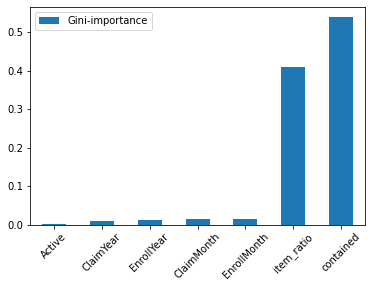

In [39]:
# Plot feature importances for best model
best_model = clf_tuned_rf.best_estimator_
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(feat_cols, best_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

The most important features were contained and item_ratio, followed by minor contributions from month and year of enrollment and claims, and a tiny contribution from whether the policy was active. 

The two main features make sense intuitively. The most important information we have about these data is that the vet wrote down one name and the policy has another - the vet being the third party outsider who brings some extra information to what we have internally. Contained tells us that the policy and the vet record names have a significant portion that are an exact match - one of those names being fully contained within the other - which helps with nick names, abbreviated names, honorifics, and those kinds of cases. However, there is another big class of cases where the edit distance (and specifically, how many edits in relation to the name in the line item data) is important to help address misspellings, typos, errant punctuation, and those kinds of cases. Between these two features, we're able to capture most of the variability in the training set. 

# Final predictions on unseen data

In [40]:
# Test set predictions
X_unseen = df_test[feat_cols]
#X_unseen = df_test[nonzero_coef.keys()]
y_pred_unseen = best_model.predict(X_unseen)

#combine predictions with original data and write to file
claims_test = claims.loc[df_test.index]
claims_test['WrongPetFlag_Pred'] = y_pred_unseen
claims_test.to_csv('predicted_flags.csv')

In [41]:
claims_test.shape, y_pred_unseen.shape

((2000, 24), (2000,))

## Sanity check the unseen data predictions
We want to see:
* A healthy mix of 0s and 1s
* That mix should resemble the training set, more or less
* Recognizable splits in the features based on the label and our important features

I also skimmed the output predicted_flags.csv file to get a sense of how well the predictions did.

In [42]:
# How many predicted of each class in the unseen data? % of total
unique, counts = np.unique(y_pred_unseen, return_counts=True)
print(np.asarray((unique, counts/len(y_pred_unseen))).T)

[[0.     0.8285]
 [1.     0.1715]]


In [43]:
# How many predicted of each class in the test data? % of total
unique, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((unique, counts/len(y_pred))).T)

[[0.         0.84583333]
 [1.         0.15416667]]


In [44]:
# What are the splits in the data based on predicted label?
claims_test.groupby('WrongPetFlag_Pred').mean().T
claims_test.columns
x=claims_test.drop(columns=to_drop)
x.groupby('WrongPetFlag_Pred').mean().T

WrongPetFlag_Pred,0.0,1.0
PolicyId,14560.612553,13164.174927
OwnerId,13389.006035,10664.956268
ClaimId,18322.488835,17777.218659
LineItemId,18999.468920,18999.650146
WrongPetFlag,NaN,NaN
item_ratio,0.097697,0.939044
contained,1.000000,0.000000
ClaimMonth,6.306578,6.393586
ClaimYear,2018.690404,2018.393586
Active,0.633675,0.594752


Contained was very , very strongly split between the labels. item_ratio, our 2nd most important feature, was also very well split though not quite a stark. The lesser important features, like month/year and active, had smaller splits, as expected.

The classifer is generating a healthy mix of labels that is pretty similar to the mix in the training dataset, which is very nice sanity check that prompted me to do some interating as noted earlier. 

# Summary

Given two data sets of veternary recorded line item data and Trupanion-internal policy information, I cleaned the data to handle nulls and outliers. Then I created several new features. 
* Most were related to several simple measures of similaritity between the recorded pet names, as this was the only information we had about them. If we had additional data, such as their gender, weight, age, health status, etc. those would be useful predictors also especially if we had internal and external records of those data. 
* I also added features for seasonality and active policies, as that was the fastest and simplest way to extract usable data from the various dates. Other options would be day of week, time of day, etc. but I did not expect WrongPetFlag to be seasonaly dependent (unlike, for instance, treatments where springtime means tick prevenative measures, etc) so I felt month/year was sufficient, and that intuition was correct. 

Then I trained 2 classifiers: logistic regression and random forest. In my experience, RF is usually very performant, with added benefits around explainability and robustness to scaling; but it is always worth trying the simplest option in logistic regression as a baseline. RF was the best in this situation, so I ran it through a hyperparameter tuning with cross validation. 

Metrics reflected the need to pay attention to the class imbalance in this data, though ultimately there were no tie-breakers.

Then I predicted the unseen test data where the WrongPetFlag was missing. I joined the prediction onto the feature set with various IDs to make it easier to validated them. 

Finally, I sanity checked the predictions. I skimmed through the file, and felt the predictions were largely correct as our cross-validated metrics had suggested. I also confirmed that there was a reasonable mix of 0 and 1 labels in the predicted target variable compared to the training set. 